Importing dependencies

In [62]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.feature_extraction import DictVectorizer

Importing data

In [59]:
X_train = pd.read_pickle('../data/processed/X_train.pkl')
X_val = pd.read_pickle('../data/processed/X_val.pkl')
y_train = pd.read_pickle('../data/processed/y_train.pkl')
y_val = pd.read_pickle('../data/processed/y_val.pkl')
dv = pd.read_pickle('../data/processed/DictVectorier.pkl')
df_train_full = pd.read_pickle('../data/processed/df_train_full.pkl')
df_test = pd.read_pickle('../data/processed/df_test.pkl')

In [3]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [4]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train,y_pred)

1.0

In [5]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val,y_pred)

0.6492667893729869

This is the case of overfitting. The tree learned the training data so well it simply memorized the outcome for each customer and when we applied to the validation set, the model failed.

There are multiple ways of controlling the complexity of a tree. One of the options is restricting its size: we can specify the max_depth parameter (a tree with more levels can learn more complex rules. A tree with two levels is less exmplex than a tree with three levels, and thus less prone to overfitting.)

The default value of max_depth is None which means that the tree can grow as large as possible. We can try smaller values

In [6]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


We can use the export_text function to visualize the tree we just learned

In [7]:
tree_text = export_text(dt,feature_names=dv.feature_names_)
print(tree_text)

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- class: False
|   |--- job=partime >  0.50
|   |   |--- class: True
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- class: True
|   |--- seniority >  6.50
|   |   |--- class: False



In [8]:
y_pred = dt.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_train,y_pred)
print('train auc',auc)

y_pred = dt.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val,y_pred)
print('validation auc',auc)

train auc 0.7054989859726213
validation auc 0.6685264343319367


By making it less complex, we improved the ability of our model to generalize

Parameter tuning for decision tree

There are two parameters we can tune:
* max_depth
* min_leaf_size

In [9]:
# we will start by tuning max_depth by iterating through possible values
for depth in [1,2,3,4,5,6,10,15,20,None]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train,y_train)
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val,y_pred)
    print('%4s -> %.3f' %(depth,auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.738
   4 -> 0.759
   5 -> 0.767
   6 -> 0.747
  10 -> 0.645
  15 -> 0.626
  20 -> 0.631
None -> 0.640


we see that max_depth of 5 gives the best AUC (76.6%) followed by 4 and 6

Next we'll tune min_leaf_size. We will iterate over the three best parameters of max_depth and for each, go over different values of min_leaf_size

In [10]:
for m in [4,5,6]:
    print('depth: %s' %m)
    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (s, auc))

    print() 

    

depth: 4
1 -> 0.759
5 -> 0.759
10 -> 0.759
15 -> 0.763
20 -> 0.760
50 -> 0.755
100 -> 0.754
200 -> 0.745

depth: 5
1 -> 0.767
5 -> 0.768
10 -> 0.762
15 -> 0.766
20 -> 0.766
50 -> 0.764
100 -> 0.762
200 -> 0.757

depth: 6
1 -> 0.739
5 -> 0.751
10 -> 0.761
15 -> 0.772
20 -> 0.763
50 -> 0.764
100 -> 0.771
200 -> 0.766



We can see that the best AUC is 77.2% with parameters max_depth = 6 and min_sample_leaf = 15

Now we can train the final model

In [11]:
dt = DecisionTreeClassifier(max_depth=6,min_samples_leaf=15)
dt.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Random Forest

we will specify the number of trees we want to have

In [16]:
rf = RandomForestClassifier(n_estimators=10,random_state=3)
rf.fit(X_train,y_train)

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [18]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val,y_pred)

0.7851771572497638

To see how many trees we need, we can iterate over different values for n_estimators and see its effect on AUC

In [19]:
aucs = []

for i in range(10,201,10):
    rf = RandomForestClassifier(n_estimators=i,random_state=3)
    rf.fit(X_train,y_train)
    
    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val,y_pred)
    print('%s -> %.3f' %(i,auc))
    
    aucs.append(auc)

10 -> 0.785
20 -> 0.811
30 -> 0.816
40 -> 0.818
50 -> 0.816
60 -> 0.815
70 -> 0.815
80 -> 0.816
90 -> 0.817
100 -> 0.818
110 -> 0.818
120 -> 0.819
130 -> 0.820
140 -> 0.819
150 -> 0.820
160 -> 0.820
170 -> 0.820
180 -> 0.821
190 -> 0.821
200 -> 0.820


we can also plot it

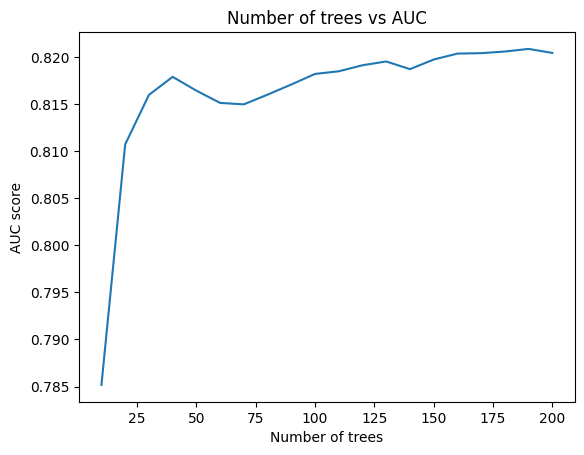

In [22]:
plt.plot(range(10,201,10),aucs)
plt.xlabel('Number of trees')
plt.ylabel('AUC score')
plt.title('Number of trees vs AUC')
plt.savefig('../plots/Number_of_trees_vs_AUC.png',dpi=300)
plt.show()

Parameter tuning for random forest

Most important parameters we need to tune for random forest are :
* max_epth
* min_leaf_size

We will start with max_depth

In [29]:
all_aucs = {} 
for depth in [5, 10, 20]: 
 print('depth: %s' % depth)
 aucs = [] 
 for i in range(10, 401, 10): 
    rf = RandomForestClassifier(n_estimators=i, max_depth=depth, random_state=1) #D
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred) 
    print('%s -> %.3f' % (i, auc)) 
    aucs.append(auc) 

 all_aucs[depth] = aucs 
 print() 


depth: 5
10 -> 0.793
20 -> 0.800
30 -> 0.801
40 -> 0.800
50 -> 0.802
60 -> 0.803
70 -> 0.802
80 -> 0.805
90 -> 0.806
100 -> 0.805
110 -> 0.806
120 -> 0.807
130 -> 0.808
140 -> 0.807
150 -> 0.807
160 -> 0.807
170 -> 0.806
180 -> 0.806
190 -> 0.806
200 -> 0.806
210 -> 0.806
220 -> 0.807
230 -> 0.807
240 -> 0.807
250 -> 0.806
260 -> 0.806
270 -> 0.806
280 -> 0.806
290 -> 0.805
300 -> 0.806
310 -> 0.806
320 -> 0.806
330 -> 0.806
340 -> 0.806
350 -> 0.806
360 -> 0.805
370 -> 0.805
380 -> 0.806
390 -> 0.806
400 -> 0.806

depth: 10
10 -> 0.797
20 -> 0.805
30 -> 0.810
40 -> 0.813
50 -> 0.813
60 -> 0.816
70 -> 0.816
80 -> 0.815
90 -> 0.817
100 -> 0.817
110 -> 0.819
120 -> 0.819
130 -> 0.820
140 -> 0.820
150 -> 0.821
160 -> 0.821
170 -> 0.821
180 -> 0.821
190 -> 0.822
200 -> 0.822
210 -> 0.822
220 -> 0.822
230 -> 0.822
240 -> 0.822
250 -> 0.822
260 -> 0.823
270 -> 0.823
280 -> 0.823
290 -> 0.823
300 -> 0.823
310 -> 0.823
320 -> 0.823
330 -> 0.823
340 -> 0.823
350 -> 0.822
360 -> 0.822
370 -> 0.8

Now for each value of max_depth we have a series of AUC scores. We can plot them.

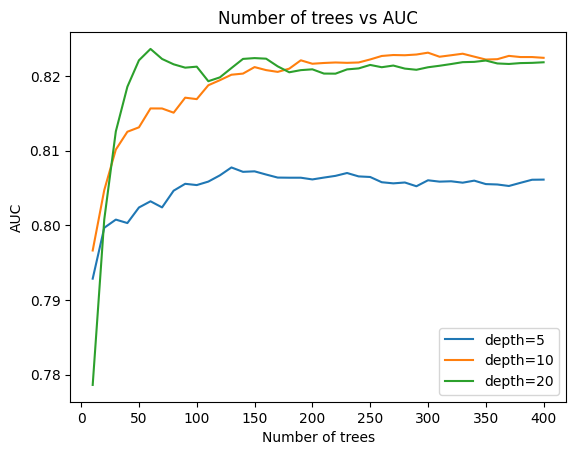

In [31]:
num_trees = list(range(10, 401, 10))
plt.plot(num_trees, all_aucs[5], label='depth=5')
plt.plot(num_trees, all_aucs[10], label='depth=10')
plt.plot(num_trees, all_aucs[20], label='depth=20')
plt.xlabel('Number of trees')
plt.ylabel('AUC')
plt.title('Number of trees vs AUC')
plt.savefig('../plots/Number_of_trees_vs_AUC_depth_tuning')
plt.legend() 


With max_depth = 10, AUC goes over 82%, while for other values it performs worse.
Now let's tune min_sample_leaf.

In [32]:
all_aucs = {}

for m in [3, 5, 10]:
 print('min_samples_leaf: %s' % m)
 aucs = []
 for i in range(10, 401, 20):
    rf = RandomForestClassifier(n_estimators=i, max_depth=10, min_samples_leaf=m,
random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (i, auc))
    aucs.append(auc)

 all_aucs[m] = aucs
 print() 

min_samples_leaf: 3
10 -> 0.800
30 -> 0.820
50 -> 0.819
70 -> 0.816
90 -> 0.818
110 -> 0.821
130 -> 0.822
150 -> 0.824
170 -> 0.823
190 -> 0.823
210 -> 0.823
230 -> 0.823
250 -> 0.823
270 -> 0.823
290 -> 0.823
310 -> 0.824
330 -> 0.824
350 -> 0.824
370 -> 0.824
390 -> 0.824

min_samples_leaf: 5
10 -> 0.787
30 -> 0.810
50 -> 0.816
70 -> 0.819
90 -> 0.821
110 -> 0.821
130 -> 0.822
150 -> 0.822
170 -> 0.822
190 -> 0.823
210 -> 0.823
230 -> 0.824
250 -> 0.824
270 -> 0.824
290 -> 0.824
310 -> 0.824
330 -> 0.824
350 -> 0.825
370 -> 0.825
390 -> 0.825

min_samples_leaf: 10
10 -> 0.804
30 -> 0.811
50 -> 0.812
70 -> 0.813
90 -> 0.817
110 -> 0.817
130 -> 0.817
150 -> 0.818
170 -> 0.818
190 -> 0.819
210 -> 0.819
230 -> 0.819
250 -> 0.819
270 -> 0.819
290 -> 0.818
310 -> 0.818
330 -> 0.818
350 -> 0.818
370 -> 0.817
390 -> 0.817



Let's Now plot it

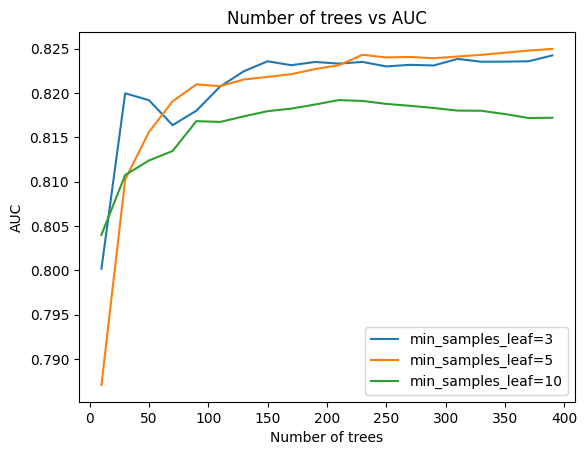

In [34]:
num_trees = list(range(10, 401, 20))
plt.plot(num_trees, all_aucs[3], label='min_samples_leaf=3')
plt.plot(num_trees, all_aucs[5], label='min_samples_leaf=5') 
plt.plot(num_trees, all_aucs[10], label='min_samples_leaf=10')
plt.xlabel('Number of trees')
plt.ylabel('AUC')
plt.title('Number of trees vs AUC')
plt.savefig('../plots/Number_of_trees_vs_AUC_min_samples_leaf.png')
plt.legend() 

We can see that AUC is slightly better for small values of min_samples_leaf, and the best value is 5

Conclusion : the best parameters for random forest for our problem are:
* max_depth = 10
* min_samples_leaf = 5

We achieved the best AUC with 190 trees, so we should set n_estimators = 190

In [35]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5,
random_state=1) 

Gradient Boosting

Before we train an XGBoost model, we need to wrap our data into DMatrix (a special data structure for finding splits efficiently)

In [37]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_) 

In [38]:
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_) 

Specifying the parameters for training

In [39]:
xgb_params = {
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'binary:logistic',
 'nthread': 8,
 'seed': 1,
 'silent':1
}

Training the XGB model

In [40]:
model = xgb.train(xgb_params, dtrain, num_boost_round=10) 

c:\Users\ghass\.virtualenvs\credit_risk_scoring-ODuNveMo\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:30:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


we have these arguments:
* xgb_params: the parameters for tuning
* dtrain: the dataset for training (an instance of DMatrix)
* num_boost_round = 10: the number of trees to train

In [42]:
y_pred = model.predict(dval)
y_pred[:10]

array([0.10656516, 0.04265971, 0.1036291 , 0.19908465, 0.11767013,
       0.1102936 , 0.05662393, 0.53019834, 0.4540083 , 0.02212273],
      dtype=float32)

The result of y_pred is a one-dimensional Numpy array with predictions

In [43]:
roc_auc_score(y_val,y_pred)

0.8150959046765639

Model performance monitoring

To see how AUC changes as the number of trees grows, we can use a watchlist - a built-in feature in XGBoost for monitoring model performance.

A watchlist is a list with tuples

In [44]:
watchlist = [(dtrain, 'train'), (dval, 'val')] 

we need also to modify the metric we use for evaluation

In [46]:
xgb_params = {
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc', 
 'nthread': 8,
 'seed': 1,
 'silent': 1
} 

To use the watchlist during training, we need to specify two extra arguments for the train function:
* evals - the watchlist
* verbose_eval - how often we print the metric. If we put '10', we will see the result each 10th step

In [47]:
model = xgb.train(xgb_params, dtrain,
 num_boost_round=100,
 evals=watchlist, verbose_eval=10) 

[0]	train-auc:0.86322	val-auc:0.76992
[10]	train-auc:0.95292	val-auc:0.81593
[20]	train-auc:0.97453	val-auc:0.81635
[30]	train-auc:0.98570	val-auc:0.81364
[40]	train-auc:0.99223	val-auc:0.81138
[50]	train-auc:0.99727	val-auc:0.80662
[60]	train-auc:0.99886	val-auc:0.80403
[70]	train-auc:0.99963	val-auc:0.80320
[80]	train-auc:0.99990	val-auc:0.80228
[90]	train-auc:0.99998	val-auc:0.80219
[99]	train-auc:0.99999	val-auc:0.80231


c:\Users\ghass\.virtualenvs\credit_risk_scoring-ODuNveMo\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:43:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


The behaviour is expected: in boosting, every next model tries to fix the mistakes from the previous step, so the score is always improving. For the vaidation score,however,it's not the case. It goes up initially but then starts to decrease.(effect of overfitting)

Parameter tuning for XGBoost

In [48]:
xgb_params = {
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'nthread': 8,
 'seed': 1,
 'silent': 1
} 
 

These parameters control the training process:
* eta: learning rate
* max_depth : the maximal allowed depth for each tree same as max_depth in DecisionTreeClassifier
* min_child_weight: the minimal number of observations in each group, same as min_leaf_size in DecisionTreeClassifier
* objective — the type of task we want to solve. For classification, it should be
binary:logistic.
* eval_metric — the metric we use for evaluation
* nthread — the number of threads we use for training the model. XGBoost is very good
at parallelizing training, so set it to the number of cores your computer has.
* seed — the seed for the random number generator, we need to set it to make sure the
results are reproducible
* silent — the verbosity of the output. When we set it to “1”, it’ll output only warnings.

Learning Rate

In boosting, each tree tries to correct the mistakes from the previous iterations. Learning rate
determines the weight of this correction. In practice:
* If eta is too large, the model starts to overfit quite early without realizing its full
potential.
* If it’s too small, we need to train too many trees before it can produce good results.

Default value is 0.3 which is good for large datasets, but in our case we need a smaller value

In [49]:
xgb_params = {
 'eta': 0.1, 
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'nthread': 8,
 'seed': 1,
 'silent': 1
} 

In [50]:
model = xgb.train(xgb_params,dtrain,num_boost_round=500,verbose_eval=10,evals=watchlist)

[0]	train-auc:0.86322	val-auc:0.76992
[10]	train-auc:0.91794	val-auc:0.80064
[20]	train-auc:0.93803	val-auc:0.81374
[30]	train-auc:0.95486	val-auc:0.81671
[40]	train-auc:0.96493	val-auc:0.81947
[50]	train-auc:0.97190	val-auc:0.82185
[60]	train-auc:0.97601	val-auc:0.82236
[70]	train-auc:0.98136	val-auc:0.82298


c:\Users\ghass\.virtualenvs\credit_risk_scoring-ODuNveMo\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:58:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[80]	train-auc:0.98532	val-auc:0.82220
[90]	train-auc:0.98788	val-auc:0.82147
[100]	train-auc:0.98979	val-auc:0.82213
[110]	train-auc:0.99142	val-auc:0.82202
[120]	train-auc:0.99291	val-auc:0.82232
[130]	train-auc:0.99420	val-auc:0.82154
[140]	train-auc:0.99537	val-auc:0.82027
[150]	train-auc:0.99667	val-auc:0.81930
[160]	train-auc:0.99738	val-auc:0.81886
[170]	train-auc:0.99790	val-auc:0.81768
[180]	train-auc:0.99826	val-auc:0.81665
[190]	train-auc:0.99855	val-auc:0.81583
[200]	train-auc:0.99891	val-auc:0.81582
[210]	train-auc:0.99924	val-auc:0.81618
[220]	train-auc:0.99949	val-auc:0.81613
[230]	train-auc:0.99964	val-auc:0.81548
[240]	train-auc:0.99978	val-auc:0.81475
[250]	train-auc:0.99982	val-auc:0.81405
[260]	train-auc:0.99985	val-auc:0.81358
[270]	train-auc:0.99991	val-auc:0.81353
[280]	train-auc:0.99994	val-auc:0.81278
[290]	train-auc:0.99996	val-auc:0.81282
[300]	train-auc:0.99998	val-auc:0.81206
[310]	train-auc:0.99998	val-auc:0.81154
[320]	train-auc:0.99999	val-auc:0.81096
[3

After running it, we see that the best validation score is 0.823

Tuning max_depth

The default value is 6, we can try a lower value 3 and a higher value 10

In [52]:
xgb_params = {
 'eta': 0.1,
 'max_depth': 3, 
 'min_child_weight': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'nthread': 8,
 'seed': 1,
 'silent': 1
}

In [53]:
model = xgb.train(xgb_params,dtrain,num_boost_round=500,verbose_eval=10,evals=watchlist)

[0]	train-auc:0.77270	val-auc:0.73762
[10]	train-auc:0.84583	val-auc:0.78595
[20]	train-auc:0.86794	val-auc:0.80896
[30]	train-auc:0.87931	val-auc:0.81488
[40]	train-auc:0.88865	val-auc:0.82145
[50]	train-auc:0.89653	val-auc:0.82572
[60]	train-auc:0.90212	val-auc:0.82821
[70]	train-auc:0.90692	val-auc:0.82945
[80]	train-auc:0.91090	val-auc:0.83012
[90]	train-auc:0.91488	val-auc:0.83077
[100]	train-auc:0.91808	val-auc:0.83113
[110]	train-auc:0.92080	val-auc:0.83304
[120]	train-auc:0.92318	val-auc:0.83276
[130]	train-auc:0.92605	val-auc:0.83268
[140]	train-auc:0.92836	val-auc:0.83206
[150]	train-auc:0.93059	val-auc:0.83123
[160]	train-auc:0.93259	val-auc:0.83169
[170]	train-auc:0.93474	val-auc:0.83159
[180]	train-auc:0.93695	val-auc:0.83179


c:\Users\ghass\.virtualenvs\credit_risk_scoring-ODuNveMo\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:09:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[190]	train-auc:0.93887	val-auc:0.83135
[200]	train-auc:0.94051	val-auc:0.83014
[210]	train-auc:0.94248	val-auc:0.83046
[220]	train-auc:0.94364	val-auc:0.82961
[230]	train-auc:0.94486	val-auc:0.82902
[240]	train-auc:0.94631	val-auc:0.82877
[250]	train-auc:0.94803	val-auc:0.82822
[260]	train-auc:0.94977	val-auc:0.82827
[270]	train-auc:0.95135	val-auc:0.82756
[280]	train-auc:0.95241	val-auc:0.82744
[290]	train-auc:0.95384	val-auc:0.82685
[300]	train-auc:0.95508	val-auc:0.82630
[310]	train-auc:0.95664	val-auc:0.82561
[320]	train-auc:0.95764	val-auc:0.82596
[330]	train-auc:0.95889	val-auc:0.82608
[340]	train-auc:0.95980	val-auc:0.82576
[350]	train-auc:0.96087	val-auc:0.82583
[360]	train-auc:0.96210	val-auc:0.82534
[370]	train-auc:0.96324	val-auc:0.82487
[380]	train-auc:0.96411	val-auc:0.82464
[390]	train-auc:0.96506	val-auc:0.82427
[400]	train-auc:0.96569	val-auc:0.82366
[410]	train-auc:0.96629	val-auc:0.82345
[420]	train-auc:0.96787	val-auc:0.82236
[430]	train-auc:0.96899	val-auc:0.82229


Best auc we got is val-auc : 0.83179

Let's Now try 10

In [54]:
xgb_params = {
 'eta': 0.1,
 'max_depth': 10, 
 'min_child_weight': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'nthread': 8,
 'seed': 1,
 'silent': 1
}

In [55]:
model = xgb.train(xgb_params,dtrain,num_boost_round=500,verbose_eval=10,evals=watchlist)

[0]	train-auc:0.91304	val-auc:0.77321
[10]	train-auc:0.98168	val-auc:0.79308
[20]	train-auc:0.99391	val-auc:0.80447
[30]	train-auc:0.99840	val-auc:0.80483
[40]	train-auc:0.99956	val-auc:0.80673
[50]	train-auc:0.99983	val-auc:0.80953
[60]	train-auc:0.99995	val-auc:0.81172
[70]	train-auc:0.99999	val-auc:0.81070


c:\Users\ghass\.virtualenvs\credit_risk_scoring-ODuNveMo\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:11:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[80]	train-auc:1.00000	val-auc:0.81025
[90]	train-auc:1.00000	val-auc:0.81033
[100]	train-auc:1.00000	val-auc:0.81030
[110]	train-auc:1.00000	val-auc:0.80905
[120]	train-auc:1.00000	val-auc:0.80784
[130]	train-auc:1.00000	val-auc:0.80698
[140]	train-auc:1.00000	val-auc:0.80569
[150]	train-auc:1.00000	val-auc:0.80506
[160]	train-auc:1.00000	val-auc:0.80498
[170]	train-auc:1.00000	val-auc:0.80468
[180]	train-auc:1.00000	val-auc:0.80426
[190]	train-auc:1.00000	val-auc:0.80395
[200]	train-auc:1.00000	val-auc:0.80438
[210]	train-auc:1.00000	val-auc:0.80428
[220]	train-auc:1.00000	val-auc:0.80416
[230]	train-auc:1.00000	val-auc:0.80357
[240]	train-auc:1.00000	val-auc:0.80342
[250]	train-auc:1.00000	val-auc:0.80312
[260]	train-auc:1.00000	val-auc:0.80304
[270]	train-auc:1.00000	val-auc:0.80271
[280]	train-auc:1.00000	val-auc:0.80244
[290]	train-auc:1.00000	val-auc:0.80198
[300]	train-auc:1.00000	val-auc:0.80215
[310]	train-auc:1.00000	val-auc:0.80217
[320]	train-auc:1.00000	val-auc:0.80216
[3

Best value is 0.810

Selecting the optimal number of trees

In [56]:
xgb_params = {
 'eta': 0.1,
 'max_depth': 3, 
 'min_child_weight': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'nthread': 8,
 'seed': 1,
 'silent': 1
}

In [57]:
model = xgb.train(xgb_params,dtrain,num_boost_round=500,verbose_eval=10,evals=watchlist)

[0]	train-auc:0.77270	val-auc:0.73762
[10]	train-auc:0.84583	val-auc:0.78595
[20]	train-auc:0.86794	val-auc:0.80896
[30]	train-auc:0.87931	val-auc:0.81488
[40]	train-auc:0.88865	val-auc:0.82145
[50]	train-auc:0.89653	val-auc:0.82572
[60]	train-auc:0.90212	val-auc:0.82821
[70]	train-auc:0.90692	val-auc:0.82945
[80]	train-auc:0.91090	val-auc:0.83012
[90]	train-auc:0.91488	val-auc:0.83077
[100]	train-auc:0.91808	val-auc:0.83113
[110]	train-auc:0.92080	val-auc:0.83304
[120]	train-auc:0.92318	val-auc:0.83276


c:\Users\ghass\.virtualenvs\credit_risk_scoring-ODuNveMo\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:16:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[130]	train-auc:0.92605	val-auc:0.83268
[140]	train-auc:0.92836	val-auc:0.83206
[150]	train-auc:0.93059	val-auc:0.83123
[160]	train-auc:0.93259	val-auc:0.83169
[170]	train-auc:0.93474	val-auc:0.83159
[180]	train-auc:0.93695	val-auc:0.83179
[190]	train-auc:0.93887	val-auc:0.83135
[200]	train-auc:0.94051	val-auc:0.83014
[210]	train-auc:0.94248	val-auc:0.83046
[220]	train-auc:0.94364	val-auc:0.82961
[230]	train-auc:0.94486	val-auc:0.82902
[240]	train-auc:0.94631	val-auc:0.82877
[250]	train-auc:0.94803	val-auc:0.82822
[260]	train-auc:0.94977	val-auc:0.82827
[270]	train-auc:0.95135	val-auc:0.82756
[280]	train-auc:0.95241	val-auc:0.82744
[290]	train-auc:0.95384	val-auc:0.82685
[300]	train-auc:0.95508	val-auc:0.82630
[310]	train-auc:0.95664	val-auc:0.82561
[320]	train-auc:0.95764	val-auc:0.82596
[330]	train-auc:0.95889	val-auc:0.82608
[340]	train-auc:0.95980	val-auc:0.82576
[350]	train-auc:0.96087	val-auc:0.82583
[360]	train-auc:0.96210	val-auc:0.82534
[370]	train-auc:0.96324	val-auc:0.82487


We can see that the best number of trees is 110

Testing the Final model

In [60]:
y_train = (df_train_full.status == 'default').values
y_test = (df_test.status == 'default').values

In [61]:
del df_train_full['status']
del df_test['status'] 

In [63]:
dict_train = df_train_full.fillna(0).to_dict(orient='records')
dict_test = df_test.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_test = dv.transform(dict_test) 

Finally Train the XGBoost model

In [64]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=dv.feature_names_)
xgb_params = {
 'eta': 0.1,
 'max_depth': 3,
 'min_child_weight': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'nthread': 8,
 'seed': 1,
 'silent': 1
}
num_trees = 160
model = xgb.train(xgb_params, dtrain, num_boost_round=num_trees) 

c:\Users\ghass\.virtualenvs\credit_risk_scoring-ODuNveMo\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:24:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [65]:
y_pred_xgb = model.predict(dtest)
roc_auc_score(y_test, y_pred_xgb)

0.8319730218464396

Conclusion: We got 83.1% which is comparable to what we found earlier during training so the model can generalize well.